# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.479931,True,6.266536
1,0.857590,True,7.154211
2,1.322035,True,5.860193
3,0.412127,True,6.596416
4,-0.284940,True,4.354296
...,...,...,...
995,0.443254,True,6.084640
996,0.625783,False,-0.950551
997,0.343216,False,0.173432
998,1.552630,True,6.245845


<AxesSubplot: xlabel='v0'>

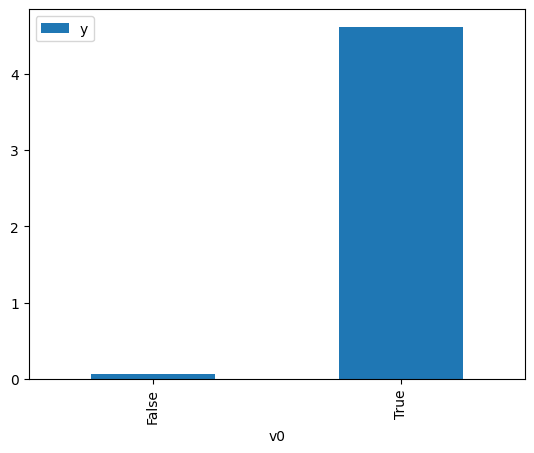

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

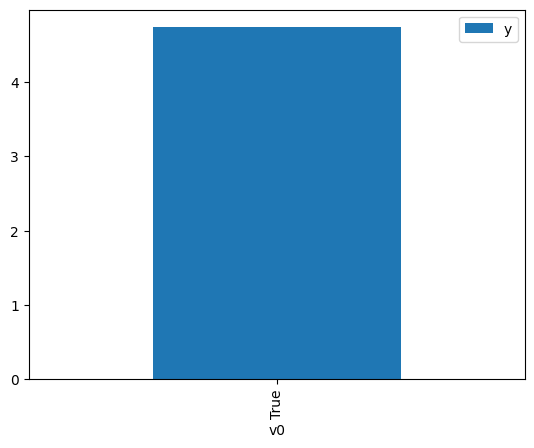

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.147594,False,-1.489009,0.839491,1.191198
1,-1.224206,False,-1.083977,0.853186,1.172077
2,-1.626507,False,-1.657608,0.909957,1.098953
3,0.332940,False,0.227194,0.405696,2.464901
4,1.212798,False,0.804627,0.169118,5.913031
...,...,...,...,...,...
995,1.176439,False,0.620170,0.176261,5.673391
996,-0.465615,False,-1.707500,0.671835,1.488461
997,0.153656,False,-1.488597,0.466249,2.144779
998,0.884249,False,0.548210,0.242316,4.126844


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,2.155956,True,8.655479,0.947303,1.055629
1,0.737780,True,5.611723,0.718813,1.391183
2,-0.300838,True,4.770967,0.379924,2.632107
3,-1.117746,True,3.117980,0.166118,6.019832
4,-0.170365,True,4.089189,0.423010,2.364008
...,...,...,...,...,...
995,2.651567,True,7.740019,0.972633,1.028137
996,0.502806,True,4.438522,0.649174,1.540419
997,-0.128812,True,4.011738,0.437017,2.288242
998,0.577194,True,3.975429,0.672105,1.487864


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                              7634.
Date:                Thu, 02 Feb 2023   Prob (F-statistic):                        0.00
Time:                        06:04:08   Log-Likelihood:                         -1413.0
No. Observations:                1000   AIC:                                      2830.
Df Residuals:                     998   BIC:                                      2840.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9716      0.032     30.003      0.000       0.908       1.035
x2             4.9677      0.049    102.326      0.000       4.872       5.063
==============================================================================
Omnibus:                        2.694   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                2.564
Skew:                           0.098   Prob(JB):                        0.278
Kurtosis:                       3.152   Cond. No.                         1.73
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""